In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K


In [3]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image 
from skimage.io import imread as imread_raw
import tensorflow as tf


In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence

In [15]:
input_dir = os.path.join('/content','drive','MyDrive','research2')
segmentation_dir = os.path.join(input_dir,'segmentation')
segmentation_test_dir = os.path.join(segmentation_dir,'test_ic')
segmentation_train_dir = os.path.join(segmentation_dir,'train_ic')
segmentation_aug_dir = os.path.join(segmentation_train_dir,'augmentation')
segmentation_image_dir = os.path.join(segmentation_train_dir,'image')
segmentation_mask_dir= os.path.join(segmentation_train_dir,"mask")
segmentation_dilate_dir = os.path.join(segmentation_train_dir,"dilate")
shenzhen_train_dir = os.path.join(input_dir,"ChinaSet_AllFiles")
shenzhen_image_dir = os.path.join(shenzhen_train_dir,"CXR_png")
shenzhen_mask_dir = os.path.join(shenzhen_train_dir,"mask","mask1")
montgomery_train_dir = os.path.join(input_dir,"MontgomerySet")
montgomery_image_dir = os.path.join(montgomery_train_dir,"CXR_png")
montgomery_left_mask_dir = os.path.join(montgomery_train_dir,"ManualMask","leftMask")
montgomery_right_mask_dir = os.path.join(montgomery_train_dir ,"ManualMask","rightMask")
DILATE_KERNEL = np.ones((15, 15), np.uint8)
BATCH_SIZE=2
EPOCHS=56

In [16]:
print(input_dir)
print(segmentation_dir)
print(segmentation_test_dir)
print(segmentation_train_dir)
print(segmentation_aug_dir)
print(segmentation_image_dir)
print(segmentation_mask_dir)
print(segmentation_dilate_dir)
print(shenzhen_train_dir)
print(shenzhen_image_dir)
print(shenzhen_mask_dir)
print(montgomery_train_dir)
print(montgomery_image_dir)
print(montgomery_left_mask_dir)
print(montgomery_right_mask_dir)

/content/drive/MyDrive/research2
/content/drive/MyDrive/research2/segmentation
/content/drive/MyDrive/research2/segmentation/test_ic
/content/drive/MyDrive/research2/segmentation/train_ic
/content/drive/MyDrive/research2/segmentation/train_ic/augmentation
/content/drive/MyDrive/research2/segmentation/train_ic/image
/content/drive/MyDrive/research2/segmentation/train_ic/mask
/content/drive/MyDrive/research2/segmentation/train_ic/dilate
/content/drive/MyDrive/research2/ChinaSet_AllFiles
/content/drive/MyDrive/research2/ChinaSet_AllFiles/CXR_png
/content/drive/MyDrive/research2/ChinaSet_AllFiles/mask/mask1
/content/drive/MyDrive/research2/MontgomerySet
/content/drive/MyDrive/research2/MontgomerySet/CXR_png
/content/drive/MyDrive/research2/MontgomerySet/ManualMask/leftMask
/content/drive/MyDrive/research2/MontgomerySet/ManualMask/rightMask


In [18]:
montgomery_left_mask_dir_1 = glob(os.path.join(montgomery_left_mask_dir, '*.png'))
montgomery_test = montgomery_left_mask_dir_1[0:50]
montgomery_train= montgomery_left_mask_dir_1[50:]



In [19]:
def add_colored_dilate(image,mask_image,dilate_image):
     mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)
     dilate_image_gray = cv2.cvtColor(dilate_image,cv2.COLOR_BGR2GRAY)
     mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)
     dilate = cv2.bitwise_and(dilate_image,dilate_image,mask=dilate_image_gray)
     mask_coord = np.where(mask!=[0,0,0])
     dilate_coord = np.where(dilate!=[0,0,0])

     mask[mask_coord[0],mask_coord[1],:] = [255,0,0]
     dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

     ret = cv2.addWeighted(image,0.7,dilate,0.3,0)
     ret = cv2.addWeighted(ret,0.7,mask,0.3,0)

     return ret
def add_colored_mask(image,mask_image):
    mask_image_grey = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_grey)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(image,0.7,mask,0.3,0)

    return ret
def diff_mask(ref_image,mask_image):
    mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(ref_image,0.7,mask,0.3,0)
    return ret




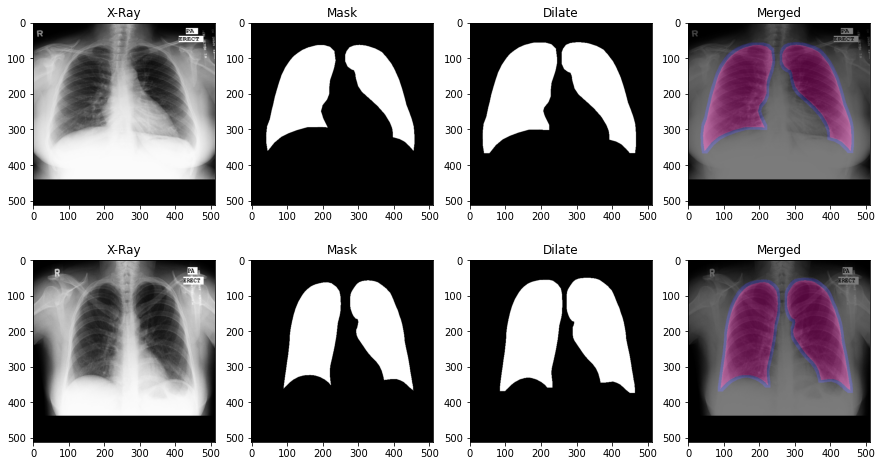

In [20]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(segmentation_image_dir,base_file)
mask_image_file = os.path.join(segmentation_mask_dir,base_file)

dilate_image_file = os.path.join(segmentation_dilate_dir,base_file)
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
fig, axs = plt.subplots( 2, 4, figsize=(15, 8))
axs[0,0].set_title("X-Ray")
axs[0,0].imshow(image)

axs[0,1].set_title("Mask")
axs[0,1].imshow(mask_image)
  
axs[0,2].set_title('Dilate')
axs[0,2].imshow(dilate_image)

axs[0,3].set_title("Merged")
axs[0,3].imshow(merged_image)


base_file = os.path.basename(montgomery_test[0])
filename,fileext  = os.path.splitext( base_file)
image_file = os.path.join(segmentation_test_dir,base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                                  "%s_mask%s" %(filename,fileext) )
dilate_image_file = os.path.join(segmentation_test_dir, \
                                    "%s_dilate%s" %(filename,fileext))
image = cv2.imread(image_file)

mask_image =cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)




In [21]:
shenzhen_mask_dir_1 = glob(os.path.join(shenzhen_mask_dir,'*.png'))
shenzhen_test = shenzhen_mask_dir_1[0:50]
shenzhen_train = shenzhen_mask_dir_1[50:]



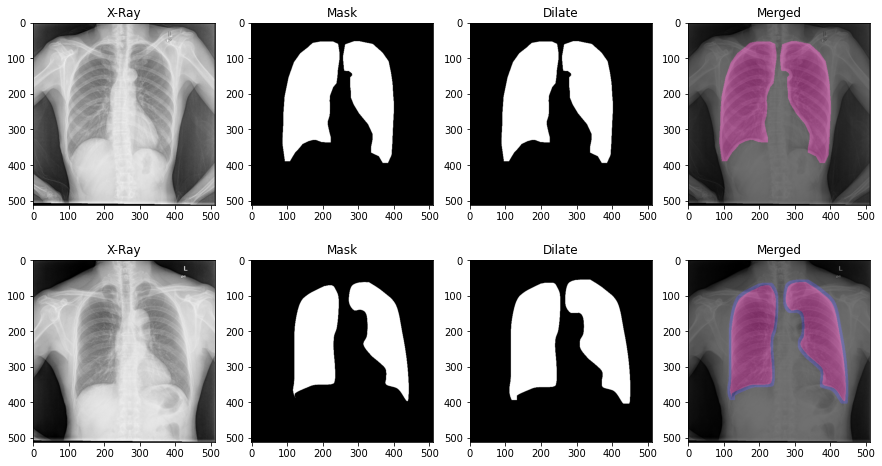

In [22]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask",""))
image_file = os.path.join(segmentation_image_dir,base_file)
mask_image_file = os.path.join(segmentation_dilate_dir,base_file)
dilate_image_file = os.path.join(segmentation_dilate_dir,base_file)
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
fig,axs = plt.subplots(2,4,figsize=(15,8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask",""))
image_file = os.path.join(segmentation_test_dir,base_file)
filename,fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(segmentation_test_dir, base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext))
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [23]:
train_files = glob(os.path.join(segmentation_image_dir, "*.png"))
test_files = glob(os.path.join(segmentation_test_dir, "*.png"))
mask_files = glob(os.path.join(segmentation_mask_dir, "*.png"))
dilate_files = glob(os.path.join(segmentation_dilate_dir, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(604, 300, 604, 604)

In [24]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [25]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [26]:
def mean_iou(y_true, y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)  
  
def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())



def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


  

In [27]:
def ic_net(input_size=(512,512,1)):
    inp = Input(input_size)
     # (1/2)
    x = Lambda(lambda x: (x - 127.5)/255.0)(inp)

    # (1/2)
    y = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2)), name='data_sub2')(x)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_1_3x3_s2')(y)
    y = BatchNormalization(name='conv1_1_3x3_s2_bn')(y)
    y = Conv2D(32, 3, padding='same', activation='relu', name='conv1_2_3x3')(y)
    y = BatchNormalization(name='conv1_2_3x3_s2_bn')(y)
    y = Conv2D(64, 3, padding='same', activation='relu', name='conv1_3_3x3')(y)
    y = BatchNormalization(name='conv1_3_3x3_bn')(y)
    y_ = MaxPooling2D(pool_size=3, strides=2, name='pool1_3x3_s2')(y)
    
    y = Conv2D(128, 1, name='conv2_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv2_1_1x1_proj_bn')(y)
    y_ = Conv2D(32, 1, activation='relu', name='conv2_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(name='padding1')(y_)
    y_ = Conv2D(32, 3, activation='relu', name='conv2_1_3x3')(y_)
    y_ = BatchNormalization(name='conv2_1_3x3_bn')(y_)
    y_ = Conv2D(128, 1, name='conv2_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_increase_bn')(y_)
    y = Add(name='conv2_1')([y,y_])
    y_ = Activation('relu', name='conv2_1/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding2')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_2_3x3')(y)
    y = BatchNormalization(name='conv2_2_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_2_1x1_increase')(y)
    y = BatchNormalization(name='conv2_2_1x1_increase_bn')(y)
    y = Add(name='conv2_2')([y,y_])
    y_ = Activation('relu', name='conv2_2/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding3')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_3_3x3')(y)
    y = BatchNormalization(name='conv2_3_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_3_1x1_increase')(y)
    y = BatchNormalization(name='conv2_3_1x1_increase_bn')(y)
    y = Add(name='conv2_3')([y,y_])
    y_ = Activation('relu', name='conv2_3/relu')(y)

    y = Conv2D(256, 1, strides=2, name='conv3_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv3_1_1x1_proj_bn')(y)
    y_ = Conv2D(64, 1, strides=2, activation='relu', name='conv3_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_reduce_bn')(y_) 
    y_ = ZeroPadding2D(name='padding4')(y_)
    y_ = Conv2D(64, 3, activation='relu', name='conv3_1_3x3')(y_)
    y_ = BatchNormalization(name='conv3_1_3x3_bn')(y_)
    y_ = Conv2D(256, 1, name='conv3_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_increase_bn')(y_)
    y = Add(name='conv3_1')([y,y_])
    z = Activation('relu', name='conv3_1/relu')(y)

    # (1/4)
    y_ = Lambda(lambda x:tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2)), name='conv3_1_sub4')(z)
    y = Conv2D(64, 1, activation='relu', name='conv3_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding5')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_2_3x3')(y)
    y = BatchNormalization(name='conv3_2_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_2_1x1_increase')(y)
    y = BatchNormalization(name='conv3_2_1x1_increase_bn')(y)
    y = Add(name='conv3_2')([y,y_])
    y_ = Activation('relu', name='conv3_2/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding6')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_3_3x3')(y)
    y = BatchNormalization(name='conv3_3_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_3_1x1_increase')(y)
    y = BatchNormalization(name='conv3_3_1x1_increase_bn')(y)
    y = Add(name='conv3_3')([y,y_])
    y_ = Activation('relu', name='conv3_3/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding7')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_4_3x3')(y)
    y = BatchNormalization(name='conv3_4_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_4_1x1_increase')(y)
    y = BatchNormalization(name='conv3_4_1x1_increase_bn')(y)
    y = Add(name='conv3_4')([y,y_])
    y_ = Activation('relu', name='conv3_4/relu')(y)

    y = Conv2D(512, 1, name='conv4_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv4_1_1x1_proj_bn')(y)
    y_ = Conv2D(128, 1, activation='relu', name='conv4_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(padding=2, name='padding8')(y_)
    y_ = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_1_3x3')(y_)
    y_ = BatchNormalization(name='conv4_1_3x3_bn')(y_)
    y_ = Conv2D(512, 1, name='conv4_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_increase_bn')(y_)
    y = Add(name='conv4_1')([y,y_])
    y_ = Activation('relu', name='conv4_1/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding9')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_2_3x3')(y)
    y = BatchNormalization(name='conv4_2_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_2_1x1_increase')(y)
    y = BatchNormalization(name='conv4_2_1x1_increase_bn')(y)
    y = Add(name='conv4_2')([y,y_])
    y_ = Activation('relu', name='conv4_2/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding10')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_3_3x3')(y)
    y = BatchNormalization(name='conv4_3_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_3_1x1_increase')(y)
    y = BatchNormalization(name='conv4_3_1x1_increase_bn')(y)
    y = Add(name='conv4_3')([y,y_])
    y_ = Activation('relu', name='conv4_3/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding11')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_4_3x3')(y)
    y = BatchNormalization(name='conv4_4_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_4_1x1_increase')(y)
    y = BatchNormalization(name='conv4_4_1x1_increase_bn')(y)
    y = Add(name='conv4_4')([y,y_])
    y_ = Activation('relu', name='conv4_4/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_5_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_5_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding12')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_5_3x3')(y)
    y = BatchNormalization(name='conv4_5_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_5_1x1_increase')(y)
    y = BatchNormalization(name='conv4_5_1x1_increase_bn')(y)
    y = Add(name='conv4_5')([y,y_])
    y_ = Activation('relu', name='conv4_5/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_6_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_6_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding13')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_6_3x3')(y)
    y = BatchNormalization(name='conv4_6_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_6_1x1_increase')(y)
    y = BatchNormalization(name='conv4_6_1x1_increase_bn')(y)
    y = Add(name='conv4_6')([y,y_])
    y = Activation('relu', name='conv4_6/relu')(y)

    y_ = Conv2D(1024, 1, name='conv5_1_1x1_proj')(y)
    y_ = BatchNormalization(name='conv5_1_1x1_proj_bn')(y_)
    y = Conv2D(256, 1, activation='relu', name='conv5_1_1x1_reduce')(y)
    y = BatchNormalization(name='conv5_1_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding14')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_1_3x3')(y)
    y = BatchNormalization(name='conv5_1_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_1_1x1_increase')(y)
    y = BatchNormalization(name='conv5_1_1x1_increase_bn')(y)
    y = Add(name='conv5_1')([y,y_])
    y_ = Activation('relu', name='conv5_1/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding15')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_2_3x3')(y)
    y = BatchNormalization(name='conv5_2_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_2_1x1_increase')(y)
    y = BatchNormalization(name='conv5_2_1x1_increase_bn')(y)
    y = Add(name='conv5_2')([y,y_])
    y_ = Activation('relu', name='conv5_2/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding16')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_3_3x3')(y)
    y = BatchNormalization(name='conv5_3_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_3_1x1_increase')(y)
    y = BatchNormalization(name='conv5_3_1x1_increase_bn')(y)
    y = Add(name='conv5_3')([y,y_])
    y = Activation('relu', name='conv5_3/relu')(y)

    h, w = y.shape[1:3].as_list()
    pool1 = AveragePooling2D(pool_size=(h,w), strides=(h,w), name='conv5_3_pool1')(y)
    pool1 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool1_interp')(pool1)
    pool2 = AveragePooling2D(pool_size=(h/2,w/2), strides=(h//2,w//2), name='conv5_3_pool2')(y)
    pool2 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool2_interp')(pool2)
    pool3 = AveragePooling2D(pool_size=(h/3,w/3), strides=(h//3,w//3), name='conv5_3_pool3')(y)
    pool3 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool3_interp')(pool3)
    pool6 = AveragePooling2D(pool_size=(h/4,w/4), strides=(h//4,w//4), name='conv5_3_pool6')(y)
    pool6 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool6_interp')(pool6)

    y = Add(name='conv5_3_sum')([y, pool1, pool2, pool3, pool6])
    y = Conv2D(256, 1, activation='relu', name='conv5_4_k1')(y)
    y = BatchNormalization(name='conv5_4_k1_bn')(y)
    aux_1 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='conv5_4_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding17')(aux_1)
    y = Conv2D(128, 3, dilation_rate=2, name='conv_sub4')(y)
    y = BatchNormalization(name='conv_sub4_bn')(y)
    y_ = Conv2D(128, 1, name='conv3_1_sub2_proj')(z)
    y_ = BatchNormalization(name='conv3_1_sub2_proj_bn')(y_)
    y = Add(name='sub24_sum')([y,y_])
    y = Activation('relu', name='sub24_sum/relu')(y)

    aux_2 = Lambda(lambda x:tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='sub24_sum_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding18')(aux_2)
    y_ = Conv2D(128, 3, dilation_rate=2, name='conv_sub2')(y)
    y_ = BatchNormalization(name='conv_sub2_bn')(y_)

    # (1)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_sub1')(x)
    y = BatchNormalization(name='conv1_sub1_bn')(y)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv2_sub1')(y)
    y = BatchNormalization(name='conv2_sub1_bn')(y)
    y = Conv2D(64, 3, strides=2, padding='same', activation='relu', name='conv3_sub1')(y)
    y = BatchNormalization(name='conv3_sub1_bn')(y)
    y = Conv2D(128, 1, name='conv3_sub1_proj')(y)
    y = BatchNormalization(name='conv3_sub1_proj_bn')(y)

    y = Add(name='sub12_sum')([y,y_])
    y = Activation('relu', name='sub12_sum/relu')(y)
    y = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*8, int(x.shape[2])*8)), name='sub12_sum_interp')(y)
    
    out = Conv2D(1, 1, activation='sigmoid', name='conv6_cls')(y)


    return Model(inputs=[inp],outputs=[out])

model=ic_net(input_size = (512,512,1))
model.summary()


   

    

  

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 512, 512, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
data_sub2 (Lambda)              (None, 256, 256, 1)  0           lambda_4[0][0]                   
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 128, 128, 32) 320         data_sub2[0][0]                  
____________________________________________________________________________________________

In [28]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [29]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(segmentation_test_dir, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            segmentation_train_dir,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(segmentation_aug_dir))

model = ic_net(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, mean_iou,recall,precision,sensitivity,'binary_accuracy'
                           ])
model.summary()

model_checkpoint = ModelCheckpoint('fcn8_lung_seg.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 512, 512, 1)  0           input_6[0][0]                    
__________________________________________________________________________________________________
data_sub2 (Lambda)              (None, 256, 256, 1)  0           lambda_5[0][0]                   
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 128, 128, 32) 320         data_sub2[0][0]                  
____________________________________________________________________________________________